# Terrific Translation with Transformers

Transformers were developed in the natural language processing (NLP) domain and now form a key component of the cutting edge deep learning architectures, including the recent architecture [Stable Diffusion](https://en.wikipedia.org/wiki/Stable_Diffusion).

In this demo, we will focus on the NLP domain and build a transformer from scratch to translate German to English. Our code is based on the excellent pytorch tutorial [here](https://pytorch.org/tutorials/beginner/translation_transformer.html).

## Libraries! Bibliotheken!

We start by loading the (numerous) libraries we will use.

In [1]:
# All libraries
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from timeit import default_timer as timer
import seaborn as sns
import matplotlib.pyplot as plt

## Language Set Up

In order to work with language, we need to convert words as we read them in letters to "tokens" which are a numeric representation. This process is called tokenization and we will install both the dataset and tokenizers for English and German on our machine. (The following code should only be run once and should take about a minute to run.)

In [2]:
first_run = False
# Run once to install dataset and tokenizers for English and German
if first_run:
  !pip install -U torchdata
  !pip install -U spacy
  !python -m spacy download en_core_web_sm
  !python -m spacy download de_core_news_sm

Now we will load the datasets and store the tokenizers.

In [3]:
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
  language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}
  for data_sample in data_iter:
    yield token_transform[language](data_sample[language_index[language]])

There are special characters which will use to structure the sequences of tokens (representing sentences of words). The `<box>` token starts a sequence while the `<eos>` token ends it. `<pad>` is used for sequences of length less than the maximum and `<unk>` is used for unknown words.

In [6]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0,1,2,3
special_symbols = ['<unk>', '<pad>', '<box>', '<eos>']

for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  vocab_transform[language] = build_vocab_from_iterator(yield_tokens(train_iter, language),
                                                        specials=special_symbols)
                                                        
for language in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[language].set_default_index(UNK_IDX)

## Seq2Seq Network

We will use the Seq2Seq model introduced in "[Attention Is All You Need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)".

The first step of the model is to embed the tokenized words into a smaller latent space that captures the meaning of the words.

In [7]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

Unlike recurrent networks, self-attention does not automatically capture the order that words appear. We need to fix this with a special positional encoding. Naive positional encodings like a one-hot approach or normalizing the index between $[0,1]$ fail due to variable sequence lenghts. The very clever solution in the original paper is to use a vector of sinusoidal functions at different frequencies. The video linked [here](https://www.youtube.com/watch?v=dichIcUZfOw) provides a high-level introduction while the article [here](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) explains more of the math behind why they work. In particular, the positional encoding is able to capture the *relative* distance between indices.

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

Now that we have the tools to embed the tokens, we will define the transformer architecture. Notice that all the exciting self-attention gets hidden under the hood in `Transformer`. We will peel this back a little at the end when we investigate the weights of the self-attention mechanism.

In [9]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, num_encoder_layers: int, num_decoder_layers: int, emb_size: int,
                 nhead: int, src_vocab_size: int, tgt_vocab_size: int, dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size, nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self, src: Tensor, trg: Tensor, src_mask: Tensor, tgt_mask: Tensor,
                src_padding_mask: Tensor, tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

A key part of training is hiding the tokens we haven't seen yet (otherwise, the problem would be very easy!).

In [10]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

## Initialization

We initialize the model with the standard hyperparameters chosen in the original paper. The resulting number of parameters is huge!!

In [11]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 128
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)


We will use the Xavier initialization (Gaussian with a special variance) in order to keep the norm of the weights close to 1.

In [12]:
count = 0
for p in transformer.parameters():
    count += p.numel()
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Architecture
transformer = transformer.to(DEVICE)
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
# Optimization method
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

print(f'There are {count} parameters in the model!')

There are 33570389 parameters in the model!


We will also need some helper functions for processing the inputs.

In [13]:
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

## Training

Finally, we will get to train the model!

In [14]:
def run(model, runtype: str, optimizer=None):
  assert runtype in ['train', 'valid']
  if runtype == 'train': model.train()
  else: model.eval()
  
  losses = 0
  data_iter = Multi30k(split=runtype, language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
  dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
  num_points = 0

  for src, tgt in dataloader:
    num_points += src.shape[1]
    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)

    tgt_input = tgt[:-1, :]

    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

    logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask,
                   tgt_padding_mask, src_padding_mask)
    
    if runtype == 'train': optimizer.zero_grad()

    tgt_out = tgt[1:, :]
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

    if runtype == 'train':
      loss.backward()
      optimizer.step()
    
    losses += loss.item()
  
  return losses / num_points


Even though the model has more than 30 million parameters, we'll be able to train it for 10 epochs (in about 6 minutes on colab GPU). While not perfect, the results are pretty good!

In [15]:
NUM_EPOCHS = 10

for epoch in range(NUM_EPOCHS):
  start_time = timer()
  train_loss = run(transformer, runtype='train', optimizer=optimizer)
  end_time = timer()
  val_loss = run(transformer, runtype='valid')
  print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 0, Train loss: 0.042, Val loss: 0.032, Epoch time = 40.146s
Epoch: 1, Train loss: 0.029, Val loss: 0.026, Epoch time = 39.424s
Epoch: 2, Train loss: 0.025, Val loss: 0.023, Epoch time = 38.848s
Epoch: 3, Train loss: 0.022, Val loss: 0.021, Epoch time = 38.938s
Epoch: 4, Train loss: 0.019, Val loss: 0.019, Epoch time = 39.020s
Epoch: 5, Train loss: 0.018, Val loss: 0.018, Epoch time = 39.290s
Epoch: 6, Train loss: 0.016, Val loss: 0.017, Epoch time = 39.032s
Epoch: 7, Train loss: 0.015, Val loss: 0.017, Epoch time = 39.010s
Epoch: 8, Train loss: 0.014, Val loss: 0.016, Epoch time = 39.075s
Epoch: 9, Train loss: 0.013, Val loss: 0.016, Epoch time = 38.981s


## Actual Translation

We've trained the weights to give a good estimate of what German sentences correspond to in English. In order to do the translation, we'll need to pick the English words with the highest probability given by the model.

In [16]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
  src = src.to(DEVICE)
  src_mask = src_mask.to(DEVICE)

  memory = model.encode(src, src_mask)
  ys = torch.ones(1,1).fill_(start_symbol).type(torch.long).to(DEVICE)
  for i in range(max_len-1):
    memory = memory.to(DEVICE)
    tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
    out = model.decode(ys, memory, tgt_mask)
    out = out.transpose(0,1)
    prob = model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.item()
    ys = torch.cat([ys, torch.ones(1,1).type_as(src.data).fill_(next_word)], dim=0)
    if next_word == EOS_IDX:
      break
  return ys

def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<box>", "").replace("<eos>", "")

Now let's translate some German into English. For fun, we can also run this code *before* and *after* we train. Amazingly, the model works pretty well! 

In [17]:
sentences = [
    'Eine Gruppe von Menschen steht vor einem Iglu .',
]
for sentence in sentences:
  print(translate(transformer, sentence))

 A group of people standing in front of an orange cone . 


## Investigating the Self-Attention Weights

Remember that the key component of this model is self-attention. Let's take a specia look at it. First, we'll need to get some validation data to investigate with.

In [18]:

data_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
dataloader = DataLoader(data_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
source, target = next(iter(dataloader))
source = source.to(DEVICE)
target = target.to(DEVICE)

In order to run the model on the data, we'll need to get masks and embedding. Then we'll add a positional encoding and feed these through the first self-attention head in the transformer.

In [19]:
src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(source, target)
src_emb = transformer.positional_encoding(transformer.src_tok_emb(source))
encoderlayer = transformer.transformer.encoder.layers[0]
x = encoderlayer.norm1(src_emb)
output, weights = encoderlayer.self_attn(x, x, x, attn_mask = src_mask, key_padding_mask=src_padding_mask)

Now let's look at an example sentence and visualize the similarity that the model sees between embedded words.

In [20]:
index = 0
src_sentence = vocab_transform[SRC_LANGUAGE].lookup_tokens(list(source[:,index]))
tgt_sentence = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(target[:,index]))
end_index = src_sentence.index('<eos>')
print(' '.join(src_sentence).replace('<box>', '').replace('<pad>', '').replace('<eos>', ''))
print(' '.join(tgt_sentence).replace('<box>', '').replace('<pad>', '').replace('<eos>', ''))

 Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen                         
 A group of men are loading cotton onto a truck                   


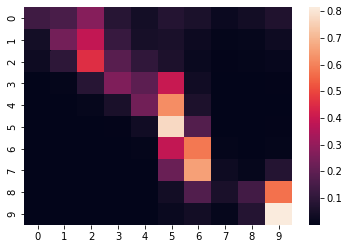

In [22]:
sns.heatmap(weights[index].detach().cpu().numpy()[:end_index, :end_index])
plt.show()